In [1]:
#run this cell before proceeding
!pip3 install screeninfo
!pip3 install dearpygui

In [1]:
import dearpygui.dearpygui as dpg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import quad, trapz


def function_y(x, M, P):
    return np.where(
        x < P,
        (2 * M / (P**2)) * (P - x),
        (2 * M / ((1 - P)**2)) * (P - x)
    )

def function_y_theta(Theta, M, P):
    a = 0.5 * (1 - np.cos(Theta))
    return np.where(
        a < P,
        (2 * M / (P**2)) * (P - a),
        (2 * M / ((1 - P)**2)) * (P - a)
    )

def integrand0(x, m, p):
    return function_y(x, m, p) * 2 / np.sqrt(1 - (1 - 2 * x)**2)

def integrand1(x, m, p):
    return function_y(x, m, p) * 2 * (1-2*x) / np.sqrt(1 - (1 - 2 * x)**2)

def integrand_n(Theta, m, p, n):
    return function_y_theta(Theta, m, p) * np.cos(n * Theta)

def A0(alpha, m, p):
    integral, o = quad(integrand0, 0, 1, args=(m, p),)
    return alpha - (1 / np.pi) * integral  # Extract only the integral value from integral() pls, made that mistake way too many times

def A1(m, p):
    integral, _ = quad(integrand1, 0, 1, args=(m, p),)
    return (2 / np.pi) * integral 

def An(m, p, n):
    integral, _ = quad(integrand_n, 0, np.pi, args=(m, p, n), limit=1000,epsabs=1e-10, epsrel=1e-10)
    return (2 / np.pi) * integral 

def C_l(alpha, m, p):
    return np.pi * (2 * A0(alpha, m, p) + A1(m, p))

def C_m(alpha, m, p):
    return -1 * (np.pi / 2) * (2 * A0(alpha, m, p) + An(m, p, 1) - (An(m, p, 2) / 2))

def update_plot(sender, app_data, user_data):
    global x, y
    choice = dpg.get_value("input_choice")
    n = dpg.get_value("num_points")
    x = np.linspace(0, 1, n)
    
    if choice == "NACA":
        # Creating n points for x from 0 to 1 including both numbers and creating points in y coordinates.
        m = dpg.get_value("max_camber") 
        p = dpg.get_value("max_camber_pos") 
        M = m/100
        P = p/10
        x = np.linspace(0, 1, n)
        y = np.where(
            x < P,
            (M/(P**2))*(2*P*x - x*x),
            (M/((1-P)**2))*((1 - 2*P) + 2*P*x - x*x)
        )
    elif choice == "Custom Function":
        func = dpg.get_value("custom_function")
        y = np.array(eval(func, {'np': np, 'x': x}))
    
    dpg.set_value("plot_series", [x.tolist(), y.tolist()])

def plot_slope(sender, app_data, user_data):
    global x, y
    choice = dpg.get_value("input_choice")
    n = dpg.get_value("num_points")
    x = np.linspace(0, 1, n)
    
    if choice == "NACA":
        # Creating n points for x from 0 to 1 including both numbers and creating points in y coordinates.
        m = dpg.get_value("max_camber") 
        p = dpg.get_value("max_camber_pos") 
        M = m/100
        P = p/10
        x = np.linspace(0, 1, n)
        dy_by_dx = function_y(x,M,P)
    else:
        dy_by_dx = np.gradient(y, x)
    dpg.set_value("plot_series",[x.tolist(),dy_by_dx.tolist()])
        
def slope_at_point():
    choice = dpg.get_value("input_choice")
    if choice == "NACA":
        M = float(dpg.get_value("max_camber")) / 100
        P = float(dpg.get_value("max_camber_pos")) / 10
        point = float(dpg.get_value("point_input"))
        dy_by_dx = np.where(
            x < P,
            (2*M/(P**2))*(P - x),
            (2*M/(1 - P)**2)*(P - x)
        )
        closest_index = np.abs(x - point).argmin()
        slope = dy_by_dx[closest_index]
        dpg.set_value("slope_output", f"Slope at {point:.2f}: {slope:.4f}")
        POINT_ON_AIRFOIL_X = x[closest_index]
        POINT_ON_AIRFOIL_Y = y[closest_index]
        dpg.configure_item("point of slope", default_value = (POINT_ON_AIRFOIL_X, POINT_ON_AIRFOIL_Y))
    else:
        dy_by_dx = np.gradient(y, x)
        point = float(dpg.get_value("point_input"))
        closest_index = np.abs(x-point).argmin()
        slope_at_point = dy_by_dx[closest_index]
        dpg.set_value("slope_output", f"Slope at {point:.2f}: {slope_at_point:.4f}")
        POINT_ON_AIRFOIL_X = x[closest_index]
        POINT_ON_AIRFOIL_Y = y[closest_index]
        dpg.configure_item("point of slope", default_value = (POINT_ON_AIRFOIL_X, POINT_ON_AIRFOIL_Y))
def calculate_cl_cm_udf():
    global x, y
    x_values = x  # Airfoil x-coordinates
    y_values = y  # Airfoil y-coordinates
    
    def integrand_0(x):
        return np.interp(x, x_values, y_values) * 2 / np.sqrt(1 - (1 - 2 * x) ** 2)
    
    def integrand_1(x):
        return np.interp(x, x_values, y_values) * 2 * (1 - 2 * x) / np.sqrt(1 - (1 - 2 * x) ** 2)
    
    A0_val, _ = quad(integrand_0, 0, 1)
    A1_val, _ = quad(integrand_1, 0, 1)
    
    def integrand_n(theta, n):
        a = 0.5 * (1 - np.cos(theta))
        return np.interp(a, x_values, y_values) * np.cos(n * theta)
    
    An1_val, _ = quad(integrand_n, 0, np.pi, args=(1,), limit=1000, epsabs=1e-10, epsrel=1e-10)
    An2_val, _ = quad(integrand_n, 0, np.pi, args=(2,), limit=1000, epsabs=1e-10, epsrel=1e-10)
    cl = np.pi * (2 * A0_val + A1_val)
    cm = -1 * (np.pi / 2) * (2 * A0_val + An1_val - (An2_val / 2))
    return cl,cm
    
def calculate_cl_cm():
    choice = dpg.get_value("input_choice")
    alpha = dpg.get_value("alpha")*np.pi / 180
    if choice == "NACA":
        M = float(dpg.get_value("max_camber")) / 100
        P = float(dpg.get_value("max_camber_pos")) / 10
        cl = C_l(alpha, M, P)
        cm = C_m(alpha, M, P)
        
    else: 
        cl,cm = calculate_cl_cm_udf()
    dpg.set_value("cl_output", f"C_l = {cl}, C_m = {cm}")

def cl_vs_alpha():
    alphas = [-3, 0, 3, 6, 9, 12]
    choice = dpg.get_value("input_choice")
    if choice == "NACA":
        M = float(dpg.get_value("max_camber")) / 100
        P = float(dpg.get_value("max_camber_pos")) / 10
        cls = [C_l(a, M, P) for a in np.radians(alphas)]
    else:
        pass
    # Update the plot with new Cl values
    dpg.set_value("cl_plot_series", [alphas, cls])
    dpg.set_value("cl_scatter_series", [alphas, cls])



# Fucntions for vector field plot
def gamma_by_u(Theta, alpha, m, p):
    # Computes (1/U_inf)*del Gamma/del x
    u = dpg.get_value("u")
    summ = A0(alpha, m, p) * ((1 + np.cos(Theta)) / (np.sin(Theta)))
    for i in range(1, 20):
        summ += An(m, p, i) * np.sin(i*Theta)
    return 0.5 * summ * u
    
def f_v_x(x, y, gamma_vals, theta_vals):
    u = dpg.get_value("u")
    f_vals = np.array([
        (gamma_val / (2 * np.pi)) * (y / ((x - (0.5 * (1 - np.cos(theta))))**2 + y**2))
        for theta, gamma_val in zip(theta_vals, gamma_vals)
    ])
    return u + trapz(f_vals, theta_vals)
"""The choice of using trapz here over quad was due to quad being very slow,
    we tried using quad but the program was taking too long to run"""

def f_v_y(x, y, gamma_vals, theta_vals):
    
    f_vals = np.array([
        (gamma_val / (2 * np.pi)) * ((x - (0.5 * (1 - np.cos(theta)))) / ((x - (0.5 * (1 - np.cos(theta))))**2 + y**2))
        for theta, gamma_val in zip(theta_vals, gamma_vals)
    ])
    return -trapz(f_vals, theta_vals)
def rotate_airfoil(x, y, alpha):
    """Applies correct rotation to airfoil coordinates."""
    cos_a, sin_a = np.cos(alpha), np.sin(alpha)
    x_shifted, y_shifted = x - x[0], y - y[0]  # Shift to origin
    x_rot = cos_a * x_shifted - sin_a * y_shifted
    y_rot = sin_a * x_shifted + cos_a * y_shifted
    return x_rot + x[0], y_rot + y[0]  # Shift back to original position

def circ_calculator(gamma_vals, theta_vals):
    method = dpg.get_value("method")
    if method =="Line Integral":
        line1_3 = np.linspace(-0.5, 0.5, 400) #this line has a constant x value of -0.2 and 1.2 respectively
        line2_4 = np.linspace(-0.2, 1.2, 560) #this line has a constant y value of 0.5 and -0.5 respectively
        
        #integral along line 1
        integral_line1, integral_line2, integral_line3, integral_line4=0,0,0,0
        
        for i in range(len(line1_3)):
            integral_line1 += f_v_y(-0.2,line1_3[i],gamma_vals, theta_vals)*(1/len(line1_3))
        for i in range(len(line1_3)):
            integral_line3 += -f_v_y(1.2,line1_3[i],gamma_vals, theta_vals)*(1/len(line1_3))
        for i in range(len(line2_4)):
            integral_line4 += -f_v_x(line2_4[i], -0.5,gamma_vals, theta_vals)*(1.4/len(line2_4))
        for i in range(len(line2_4)):
            integral_line2 += f_v_x(line2_4[i], 0.5,gamma_vals, theta_vals)*(1.4/len(line2_4))
        circ = (integral_line1+integral_line2+integral_line3+integral_line4)
    else:
        circ = np.trapz(gamma_vals,theta_vals)
    return circ

def generate_vector_field():
    global x,y
    # Create a theta array for integration.
    theta_full = np.linspace(0.0001, np.pi, 100)
    alpha = dpg.get_value("alpha")*np.pi / 180
    M = float(dpg.get_value("max_camber")) / 100
    P = float(dpg.get_value("max_camber_pos")) / 10
    
    x_air, y_air = rotate_airfoil(x , y, -alpha)
    # Compute gamma_by_u for all theta values
    gamma_full = gamma_by_u(theta_full, alpha, M, P)
    
    # Remove the first and last elements because they are outliers.
    gamma_trimmed = gamma_full[1:-1]
    theta_trimmed = theta_full[1:-1]

    # Calculate Circulation
    circulation = circ_calculator(gamma_trimmed,theta_trimmed)
    dpg.set_value("circulation", f"The net circulation is {circulation}")
    
    # Create your meshgrid for x and y.
    x_new, y_new = np.meshgrid(np.linspace(-1, 3, 40), np.linspace(-1.5, 1.5, 40))
    
    f_v_x_vec = lambda xx, yy: np.array([f_v_x(x, y, gamma_trimmed, theta_trimmed) for x, y in zip(xx, yy)])
    f_v_y_vec = lambda xx, yy: np.array([f_v_y(x, y, gamma_trimmed, theta_trimmed) for x, y in zip(xx, yy)])
    
    # Define vectorized functions. 
    f_v_x_vec = np.vectorize(lambda xx, yy: f_v_x(xx, yy, gamma_trimmed, theta_trimmed))
    f_v_y_vec = np.vectorize(lambda xx, yy: f_v_y(xx, yy, gamma_trimmed, theta_trimmed))

    

    # Compute the vector field components.
    u = f_v_x_vec(x_new, -y_new)
    v = -f_v_y_vec(x_new, -y_new)
    
    
    magnitude = np.sqrt(u**2 + v**2)     #To help make the plot more informative.max_magnitude = np.max(magnitude)
    plt.figure(figsize=(8, 6))
    Q = plt.quiver(x_new, -y_new, u, -v, magnitude, cmap='viridis')
    plt.colorbar(Q, label='Velocity Magnitude')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Vector Field')
    plt.show()

    # Normalize magnitude to colormap
    norm = plt.Normalize(vmin=np.min(magnitude), vmax=np.max(magnitude))
    colormap = cm.get_cmap("viridis")  # Same as plt.quiver
    
    def get_color(value):
        """Convert magnitude to RGB tuple using viridis colormap"""
        r, g, b, _ = colormap(norm(value))
        return int(r * 255), int(g * 255), int(b * 255), 255  # Convert to 8-bit RGBA
    
    # Scaling to fit into DPG canvas
    global scale_factor, canvas_offset_x, canvas_offset_y
    scale_factor = 100  # Initial scale
    canvas_offset_x, canvas_offset_y = 400, 400  # Canvas center
    arrow_length = 1
    
    zoom_level = 2.4
    pan_offset_x, pan_offset_y = -80, 0
    
    

    scale = scale_factor * zoom_level  # Adjusted scale
    offset_x, offset_y = canvas_offset_x + pan_offset_x, canvas_offset_y + pan_offset_y
    """Draw arrows using dpg.draw_arrow to mimic plt.quiver"""
    dpg.delete_item("vector_canvas", children_only=True)
    airfoil_scaled = [(airfoil_x * scale + offset_x, - airfoil_y * scale + offset_y) for airfoil_x, airfoil_y in zip(x_air, y_air)]
    dpg.draw_polyline(airfoil_scaled, color=(255, 255, 255, 255), thickness=2, parent="vector_canvas")  # White airfoil outline
    for i in range(x_new.shape[0]):
        for j in range(x_new.shape[1]):
            # Convert meshgrid coords to pixel space
            start_x, start_y = x_new[i, j] * scale + offset_x, y_new[i, j] * scale + offset_y
            end_x = start_x + u[i, j] * arrow_length * zoom_level
            end_y = start_y + v[i, j] * arrow_length * zoom_level # negative because dpg's coordinate system is flipped
            
            # Get color based on magnitude
            arrow_color = get_color(magnitude[i, j])
            
            # Draw arrow in DPG
            dpg.draw_arrow((end_x, end_y), (start_x, start_y), color=arrow_color, parent="vector_canvas")
def update_zoom(sender, app_data):
    """Update zoom level"""
    global zoom_level
    zoom_level = app_data
    # generate_vector_field()

def handle_pan(sender, app_data):
    """Handle panning by dragging"""
    pass
    # generate_vector_field()
def update_alpha(sender, app_data):
    """Update α (angle of attack) and redraw plot"""
    dpg.set_value("alpha",app_data) 
    generate_vector_field()
def update_u(sender, app_data):
    """Update u (free stream velocity) and redraw plot"""
    dpg.set_value("u",app_data)
    generate_vector_field()

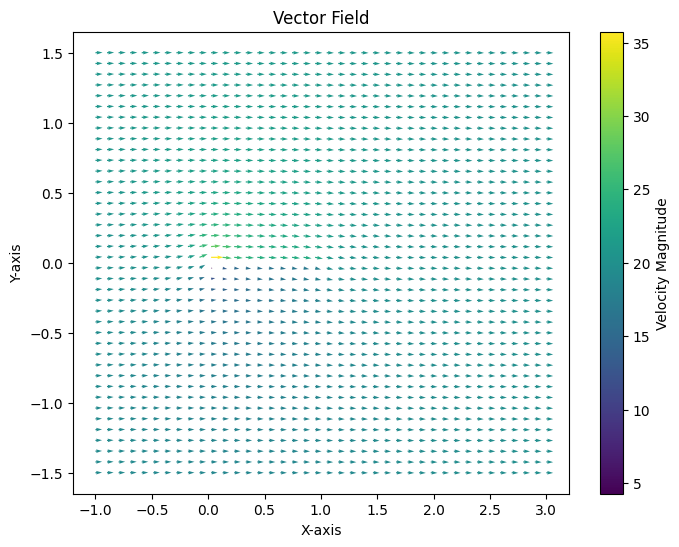

C:\Users\Ayuwan\AppData\Local\Temp\ipykernel_21840\3646047407.py:274: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap("viridis")  # Same as plt.quiver


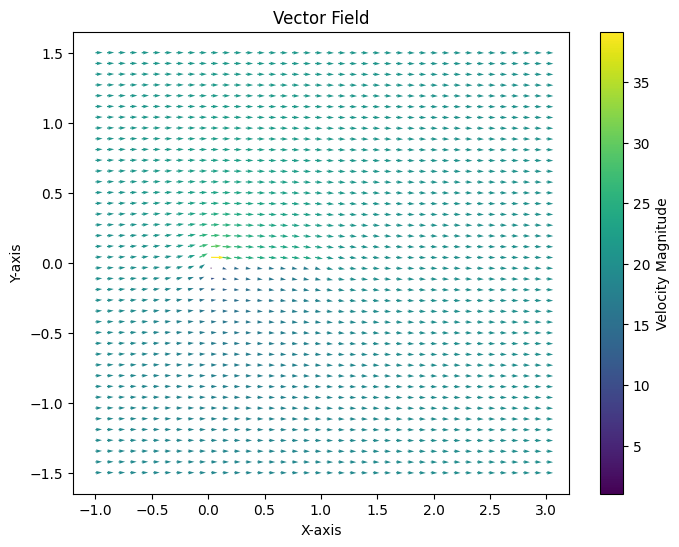

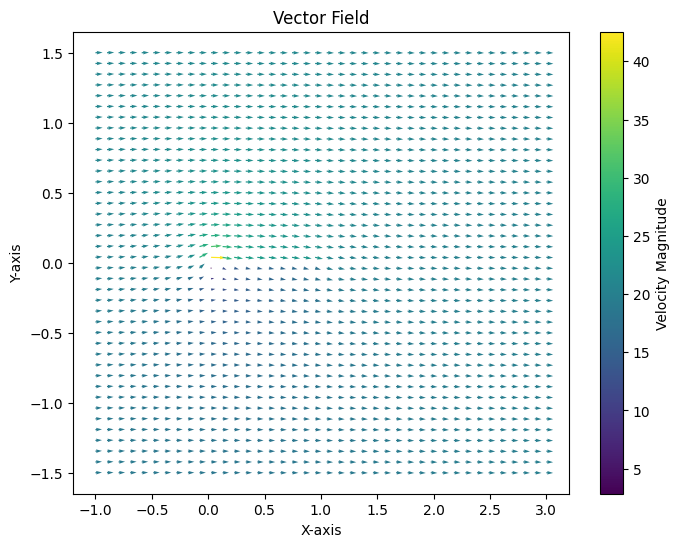

In [ ]:
import dearpygui.dearpygui as dpg
import screeninfo  # To get screen resolution

def create_gui():
    dpg.create_context()

    # Get screen resolution
    screen = screeninfo.get_monitors()[0]
    screen_width, screen_height = screen.width, screen.height

    # Create the viewport and maximize it
    dpg.create_viewport(title="Airfoil Analysis", width=screen_width, height=screen_height, always_on_top=True)
    
    # Window dimensions
    window_width = screen_width // 2
    window_height = screen_height - 100  # Leaving space for UI elements

    # Thin Airfoil Theory Window
    with dpg.window(label="Thin Airfoil Theory", width=window_width, height=window_height, pos=(0, 0)):
        dpg.add_combo(label="Input Type", items=["NACA", "Custom Function"], default_value="NACA", tag="input_choice")
        dpg.add_input_int(label="Number of Points", default_value=1000, tag="num_points")

        dpg.add_input_float(label="Max Camber (%)", default_value=2, tag="max_camber")
        dpg.add_input_float(label="Camber Position (x/c)(in tenths)", default_value=4, tag="max_camber_pos")

        dpg.add_input_text(label="Custom Function (y=f(x))", default_value="np.sin(2*np.pi*x)", tag="custom_function")
        dpg.add_button(label="Plot y vs x", callback=update_plot)
        dpg.add_button(label="Plot dy/dx vs x", callback=plot_slope)

        with dpg.plot(label="Airfoil Shape", width=window_width - 50, height=400):
            x_axis = dpg.add_plot_axis(dpg.mvXAxis, label="Chord Length")
            y_axis = dpg.add_plot_axis(dpg.mvYAxis, label="Camber Line", tag="y_axis")
            dpg.set_axis_limits(x_axis, -0.25, 1.25)
            dpg.set_axis_limits(y_axis, -0.1, 0.1)
            dpg.add_line_series([], [], label="Airfoil", parent="y_axis", tag="plot_series")
            dpg.add_plot_annotation(label="point of Slope", default_value=(0, 0), offset=(15, 15), color=[255, 255, 0, 255], tag="point of slope")

        dpg.add_input_float(label="Point for Slope", default_value=0, tag="point_input")
        with dpg.group(horizontal=True):
            dpg.add_button(label="Compute Slope", callback=slope_at_point)
            dpg.add_button(label="Unlock Axes", callback=lambda: [dpg.set_axis_limits_auto(x_axis), dpg.set_axis_limits_auto(y_axis)])
            dpg.add_button(label="Lock Axes", callback=lambda: [dpg.set_axis_limits(x_axis, -0.25, 1.25), dpg.set_axis_limits(y_axis, -0.1, 0.1)])
        dpg.add_text("", tag="slope_output")
        dpg.add_input_int(label="alpha", default_value=0, tag="alpha")
        dpg.add_button(label="Compute Cl and Cm", callback=calculate_cl_cm)
        dpg.add_text("", tag="cl_output")
        with dpg.plot(label="Cl vs Alpha", width=window_width - 50, height=300):
            cl_x_axis = dpg.add_plot_axis(dpg.mvXAxis, label="Angle of Attack (°)")
            cl_y_axis = dpg.add_plot_axis(dpg.mvYAxis, label="Coefficient of Lift (Cl)", tag="cl_y_axis")
            dpg.set_axis_limits(cl_x_axis, -5, 15)
            dpg.set_axis_limits(cl_y_axis, -0.5, 2)
            dpg.add_line_series([], [], label="Cl vs Alpha", parent="cl_y_axis", tag="cl_plot_series")
            dpg.add_scatter_series([], [], label="Data Points", parent="cl_y_axis", tag="cl_scatter_series")
        with dpg.group(horizontal=True):
            dpg.add_button(label="Generate Cl vs Alpha Plot",callback=cl_vs_alpha)
            dpg.add_button(label="Unlock Axes", callback=lambda: [dpg.set_axis_limits_auto(cl_x_axis), dpg.set_axis_limits_auto(cl_y_axis)])
            dpg.add_button(label="Lock Axes", callback=lambda: [dpg.set_axis_limits(cl_x_axis, -5, 15), dpg.set_axis_limits(cl_y_axis, -0.5, 2)])

    # Vector Field Window
    with dpg.window(label="Vector Field", width=window_width, height=window_height, pos=(window_width, 0)):
        dpg.add_button(label="Generate Vector Field", callback=generate_vector_field)
        dpg.add_slider_int(label="Angle of Attack (°)", min_value=-30, max_value=30, default_value=0, callback=update_alpha)
        dpg.add_slider_int(label="Free Stream Velocity(m/s)", min_value = 1, max_value=40, default_value=20,callback=update_u,tag="u")
        dpg.add_combo(label="Circulation calculation method", items=["Line Integral", "Vortex Filaments"], default_value="Line Integral", tag="method")
        dpg.add_text("", tag="circulation")
        with dpg.drawlist(width=window_width - 50, height=window_height - 150, tag="vector_canvas"):
            pass

    # Zoom & Pan Controls
    with dpg.handler_registry():
        dpg.add_mouse_drag_handler(callback=handle_pan)
        dpg.add_mouse_wheel_handler(callback=update_zoom)

    dpg.setup_dearpygui()
    dpg.show_viewport()
    dpg.configure_viewport(0, always_on_top=False)  # Remove always-on-top after launch
    dpg.start_dearpygui()
    dpg.destroy_context()

if __name__ == "__main__":
    create_gui()
